In [1]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import download as nltk_download
import matplotlib.pyplot as plt
import re
from pprint import pprint
# we use pathos to speed up the process of counting ngrams using multiprocessing, it is nedded because python can't pickle nummpy arrays
try:
    from pathos.multiprocessing import cpu_count, Pool
except:
    !pip install pathos
    from pathos.multiprocessing import cpu_count, Pool
from functools import partial
import seaborn as sns
nltk_download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arfel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Lendo os dados e separando as colunas que utilizaremos para a analise e juntando os dataframes

In [2]:
delivery = pd.read_csv("olist_orders_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
custumers = pd.read_csv("olist_customers_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")

# change de index to order_id
reviews.set_index("order_id", inplace=True)
delivery.set_index("order_id", inplace=True)
orders.set_index("order_id", inplace=True)
order_items.set_index("order_id", inplace=True)
custumers.set_index("customer_id", inplace=True)
sellers.set_index("seller_id", inplace=True)
# drop the columns that we don't need
reviews = reviews[["review_score", "review_comment_message", "review_creation_date"]]
delivery = delivery[["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"]]
order_items = order_items[["seller_id"]]
orders = orders[["customer_id"]]
custumers = custumers[["customer_state"]]
sellers = sellers[["seller_state"]]
# merge the two dataframes
data = pd.merge(reviews, delivery, left_index=True, right_index=True)
data = pd.merge(data, orders, left_index=True, right_index=True)
data = pd.merge(data, order_items, left_index=True, right_index=True)
# merge data and custumers when the customer_id is the same
data = pd.merge(data, custumers, left_on="customer_id", right_index=True)
# merge data and sellers when the seller_id is the same
data = pd.merge(data, sellers, left_on="seller_id", right_index=True)

data.dropna(inplace=True)
# converting the date to datetime
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])
data["order_approved_at"] = pd.to_datetime(data["order_approved_at"])
data["order_delivered_carrier_date"] = pd.to_datetime(data["order_delivered_carrier_date"])
data["order_delivered_customer_date"] = pd.to_datetime(data["order_delivered_customer_date"])
data["order_estimated_delivery_date"] = pd.to_datetime(data["order_estimated_delivery_date"])
data["review_creation_date"] = pd.to_datetime(data["review_creation_date"])

# drop the columns that we don't need anymore
data.drop(["customer_id", "seller_id"], axis=1, inplace=True)

data.head()

,review_score,review_comment_message,review_creation_date,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_state,seller_state
order_id,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,5,"Perfeito, produto entregue antes do combinado.",2017-09-21,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,RJ,SP
0188777fe321843a18be24a6e9aa1e53,5,ÓTIMO,2017-07-29,2017-07-23 16:13:37,2017-07-25 14:35:11,2017-07-27 18:45:50,2017-07-28 16:18:00,2017-08-08,RJ,SP
0191bbb5166d4b9a68df11797d5acfa9,5,Recebi o patines em perfeitas condições bem an...,2017-08-25,2017-08-10 12:17:35,2017-08-10 12:30:15,2017-08-15 19:26:45,2017-08-24 18:15:16,2017-09-08,RS,SP
0c325ea6925de749e1420be0cf43587c,4,"Atendimento excelente,o produto chegou antes d...",2017-07-11,2017-07-01 15:27:23,2017-07-01 15:43:50,2017-07-05 12:00:33,2017-07-10 17:17:21,2017-07-25,SP,SP
130898c0987d1801452a8ed92a670612,5,"lannister como sempre, entregou certinho e den...",2017-07-14,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,GO,SP


Pegando apenas os reviews negativos, pois são neles aonde conseguimos descobrir o que a empresam pode melhorar para melhor atender os seus clientes 

In [3]:
# get the reviews with less than 3 stars
unfavorable = data[data.review_score <= 3].copy()
# renaming the columns
unfavorable.columns = ["score", "comment", "review_date", "purchase_timestamp", "approved_at", "delivered_transportadora", "custumer_received", "expected_delivery", "customer_state", "seller_state"]
unfavorable.head()

,score,comment,review_date,purchase_timestamp,approved_at,delivered_transportadora,custumer_received,expected_delivery,customer_state,seller_state
order_id,,,,,,,,,,
2929e8208718655c26082e7331ef49e4,1,A loja não entregou o produto e não da explica...,2017-11-05,2017-09-27 12:32:34,2017-09-27 12:49:41,2017-09-29 17:36:40,2017-11-07 22:31:47,2017-11-03,PA,SP
34a9dd848ef0ebd4ae4b60d31720497d,1,Fiz a comprar e meu produto foi roubado entrei...,2017-11-05,2017-10-14 11:51:19,2017-10-14 12:13:47,2017-10-19 18:33:41,2017-11-14 19:19:43,2017-11-03,SP,SP
3735a11cbccd8916dbc9ccf5f671cc2c,2,bom dia....ainda não recebi o carrinho ate a d...,2017-09-04,2017-08-27 07:43:57,2017-08-27 07:55:17,2017-08-30 20:46:48,2017-09-01 18:32:17,2017-09-19,MG,SP
3c31094fbd7da6168cc190beedf23888,3,"Entrega no prazo ,produto correto falta só mai...",2017-11-02,2017-10-16 15:39:28,2017-10-17 03:46:00,2017-10-23 18:50:06,2017-11-01 19:29:47,2017-11-08,RS,SP
5a65cedc025f607cbdb4c5219f648ae3,1,Esse parceiro e muito lerdo se eu não fisesse ...,2017-10-10,2017-09-30 11:11:25,2017-09-30 11:24:47,2017-10-06 16:55:18,2017-10-09 17:46:04,2017-10-18,RJ,SP


In [86]:
pattern = re.compile("([nN][ãÃaA][oO]|[ñÑ]| [nN] )")
def re_negation(txt):
    return pattern.sub("negação", txt)

unfavorable.comment = unfavorable.comment.apply(re_negation)
unfavorable.head()

,score,comment,review_date,purchase_timestamp,approved_at,delivered_transportadora,custumer_received,expected_delivery,customer_state,seller_state,complaints_about_delivery
order_id,,,,,,,,,,,
2929e8208718655c26082e7331ef49e4,1,A loja negação entregou o produto e negação da...,2017-11-05,2017-09-27 12:32:34,2017-09-27 12:49:41,2017-09-29 17:36:40,2017-11-07 22:31:47,2017-11-03,PA,SP,False
34a9dd848ef0ebd4ae4b60d31720497d,1,Fiz a comprar e meu produto foi roubado entrei...,2017-11-05,2017-10-14 11:51:19,2017-10-14 12:13:47,2017-10-19 18:33:41,2017-11-14 19:19:43,2017-11-03,SP,SP,False
3735a11cbccd8916dbc9ccf5f671cc2c,2,bom dia....ainda negação recebi o carrinho ate...,2017-09-04,2017-08-27 07:43:57,2017-08-27 07:55:17,2017-08-30 20:46:48,2017-09-01 18:32:17,2017-09-19,MG,SP,True
3c31094fbd7da6168cc190beedf23888,3,"Entrega no prazo ,produto correto falta só mai...",2017-11-02,2017-10-16 15:39:28,2017-10-17 03:46:00,2017-10-23 18:50:06,2017-11-01 19:29:47,2017-11-08,RS,SP,False
5a65cedc025f607cbdb4c5219f648ae3,1,Esse parceiro e muito lerdo se eu negação fise...,2017-10-10,2017-09-30 11:11:25,2017-09-30 11:24:47,2017-10-06 16:55:18,2017-10-09 17:46:04,2017-10-18,RJ,SP,False


In [6]:
sw = stopwords.words('portuguese')
vec = TfidfVectorizer(max_features=500, stop_words=sw, ngram_range=(2, 4))
X = vec.fit_transform(unfavorable.comment)

def parallelize(doc, X, vec):
    wordlist = []
    n_ngram = 5

    for word in vec.vocabulary_.keys():
        word_idx = vec.vocabulary_[word]
        if X[doc, word_idx] > 0:
            wordlist.append( (X[doc,word_idx], word) )
    wordlist = sorted(wordlist, reverse=True)
    return wordlist[0:n_ngram]

with Pool(cpu_count()) as p:
    ngram = p.map(partial(parallelize, X=X, vec=vec), list(range(X.shape[0])))

Mostrando os Top 20 n-gramas mais frequentes para escolhermos qual área os clientes estão mais insatisfeitos com a empresa

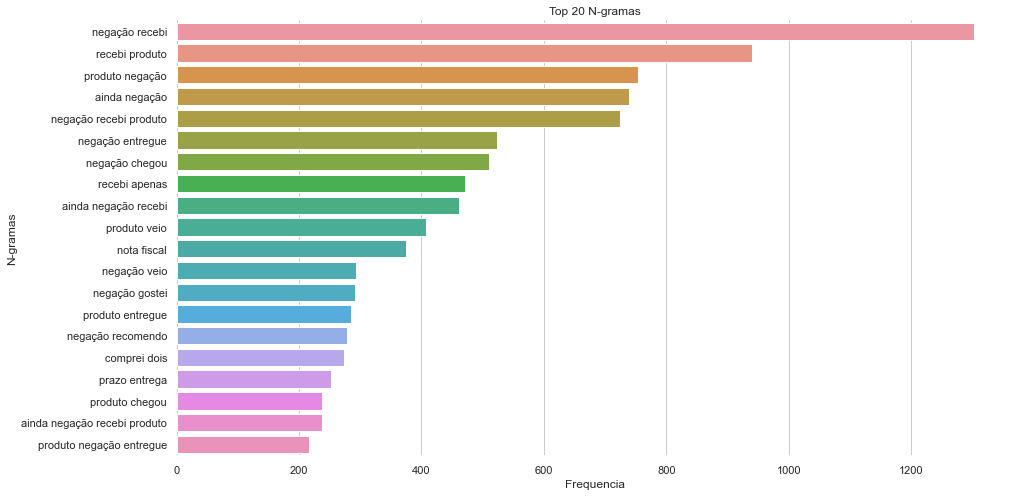

In [88]:
k = {}
for trigram in ngram:
    for j in trigram:
        if j[1] in k:
            k[j[1]] += 1
        else:
            k[j[1]] = 1

# sort the trigrams by frequency
k = sorted(k.items(), key=lambda x: x[1], reverse=True)[0:20]
# horizontal bar chart of the top 20 Trigrams
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=[i[1] for i in k], y=[i[0] for i in k])
ax.set(ylabel="N-gramas",
       xlabel="Frequencia", title="Top 20 N-gramas")
sns.despine(left=True, bottom=True)

Como vimos no gráfico anterior boa parte dos n-gramas estão falando sobre o atraso na entrega, com isso iremos identificar quais comentarios estao relacionados ao atraso de entrega e aproveitar para ver qual é a porcentagem de avaliações que estão relacionadas ao atraso de entrega

In [8]:
def check_complaint(txt):
    # list of most common ngrams that complain about delivery time
    complaints = ["negação recebi", "negação recebi produto", "negação chegou", "negação entregue", "ainda negação recebi", "prazo entrega", "ainda negação recebi produto", "produto negação entregue"]
    for complain in complaints:
        if complain in txt.lower():
            return True
    return False

# create a new collumn if the a complaint is find in a comment
unfavorable["complaints_about_delivery"] = unfavorable.comment.apply(check_complaint)

# % of complaints that are about delivery time
round(unfavorable.complaints_about_delivery.value_counts()[1]/unfavorable.shape[0] * 100, 2)

16.14

Como podemos ver pelo menos 16.14% dos reviews negativos são sobre atrasos da entrega, com isso sabemos que se a empresa melhorar nesse departamento, conseguiremos reduzir a quantidade de reviews negativos dos clientes. 

Para isso iremos testar duas hipoteses, sendo elas:

* A porcentagem de reclamacoes que sao sobre atraso de aumenta conforme vai se aproximando de alguns meses especificos.
* A transportadora atrasa mais nas entregas entre estados.

##### Vendo quantos dias de diferença existe entre o dia esperado do cliente receber o produto e o dia em que o produto foi entregue

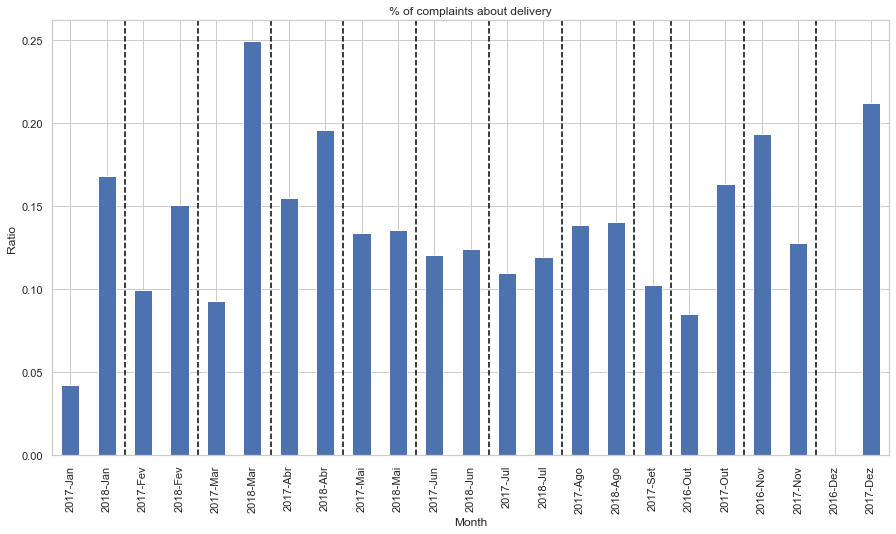

In [85]:
# % of complaints agrouped by month and year and separated if it is a complaint about delivery time
data = unfavorable.groupby([unfavorable.review_date.dt.month, unfavorable.review_date.dt.year])["complaints_about_delivery"].value_counts(normalize=True).unstack().fillna(0)
# creating a new index that is easier to read
months = {1: "Jan", 2: "Fev", 3: "Mar", 4: "Abr", 5: "Mai", 6: "Jun", 7: "Jul", 8: "Ago", 9: "Set", 10: "Out", 11: "Nov", 12: "Dez"}
new_index = []
for i in list(data.index):
    new_index.append(str(i[1]) + "-" + months[i[0]])
data.index = new_index
data.columns = ["not_about_delivery", "about_delivery"]

# plot the complaints that are about delivery time
data["about_delivery"].plot(kind="bar", stacked=True, figsize=(15, 8))
# add a vertical line to the x axis separating the months
lines = [1.5, 3.5, 5.5, 7.5, 9.5, 11.5, 13.5, 15.5, 16.5, 18.5, 20.5]
for i in lines:
    plt.axvline(i, color="black", linestyle="--")
plt.title('% of complaints about delivery')
plt.xlabel('Month')
plt.ylabel('Ratio')
plt.show()

No gráfico anterior da para se ter a impressão de que a quantidade de reclamações de atraso de entrega em alguns meses especificos porem a mudança de um ano para o outro é muito grande, diminuindo o grau de confiança que temos de que esse padrão ira se repetir nos próximos anos, com isso dificultando o investimento da empresa em na contratação de mais funcionarios para fazer as entregas nos meses de maior atividade.

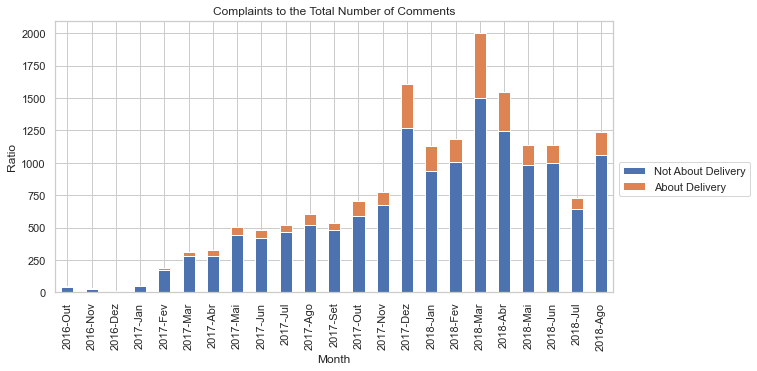

In [34]:
# frequency of complaints agrouped by month and year and separated if it is a complaint about delivery time
data = unfavorable.groupby([unfavorable.review_date.dt.year, unfavorable.review_date.dt.month])["complaints_about_delivery"].value_counts().unstack()
data.index = new_index

data.plot(kind='bar', stacked=True, figsize=(10,5))
# unfavorable.groupby(unfavorable.review_date.dt.month).complaints_about_delivery.value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Complaints to the Total Number of Comments')
plt.xlabel('Month')
plt.ylabel('Ratio')
plt.legend(['Not About Delivery', 'About Delivery'], loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:
def received2expected(row):
    expected_delivery = row.expected_delivery
    custumer_received = row.custumer_received
    return (custumer_received - expected_delivery).days

def buy2expected(row):
    purchase_timestamp = row.purchase_timestamp
    expected_delivery = row.expected_delivery
    return (expected_delivery - purchase_timestamp).days

def seller_customer_state(row):
    seller_state = row.seller_state
    customer_state = row.customer_state
    return seller_state == customer_state

# create a new df with only the complains about delivery
complaints_df = unfavorable[unfavorable.complaints_about_delivery].copy().drop(["complaints_about_delivery"], axis=1)
complaints_df["received2expected"] = complaints_df.apply(received2expected, axis=1)
complaints_df["buy2expected"] = complaints_df.apply(buy2expected, axis=1)
complaints_df["seller_customer_state"] = complaints_df.apply(seller_customer_state, axis=1)
complaints_df.head()

,score,comment,review_date,purchase_timestamp,approved_at,delivered_transportadora,custumer_received,expected_delivery,customer_state,seller_state,received2expected,buy2expected,seller_customer_state
order_id,,,,,,,,,,,,,
3735a11cbccd8916dbc9ccf5f671cc2c,2,bom dia....ainda negação recebi o carrinho ate...,2017-09-04,2017-08-27 07:43:57,2017-08-27 07:55:17,2017-08-30 20:46:48,2017-09-01 18:32:17,2017-09-19,MG,SP,-18,22,False
e6293b688f0d1387e634ae8841feca17,1,negação recebi um dos produtos. o pedido veio ...,2017-05-27,2017-05-16 11:27:08,2017-05-16 11:35:21,2017-05-19 13:40:55,2017-05-26 06:06:54,2017-06-09,PR,SP,-14,23,False
3190cee126ad6894778d3f21c28b0a55,1,negação chegou na minha casa e veio faltando p...,2017-10-24,2017-10-16 11:34:00,2017-10-16 11:49:37,2017-10-17 22:52:56,2017-10-23 19:52:17,2017-10-31,SP,SP,-8,14,True
3190cee126ad6894778d3f21c28b0a55,1,negação chegou na minha casa e veio faltando p...,2017-10-24,2017-10-16 11:34:00,2017-10-16 11:49:37,2017-10-17 22:52:56,2017-10-23 19:52:17,2017-10-31,SP,SP,-8,14,True
5f9d46795c3126674e52becb3a1a517f,1,"Por enquanto chegou só um produto, e de cor er...",2017-07-21,2017-07-18 11:48:20,2017-07-18 12:03:29,2017-07-20 23:03:42,2017-07-20 18:52:41,2017-07-31,SP,SP,-11,12,True


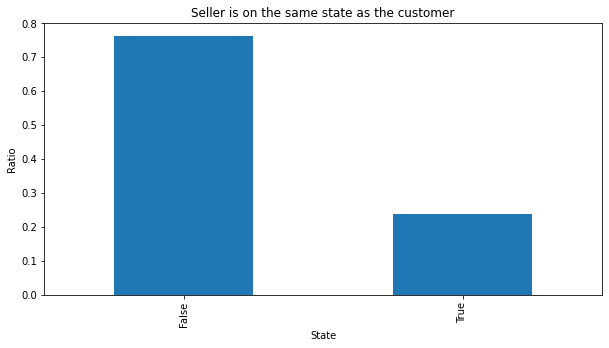

In [29]:
# plot the ratio of seller_customer_state
complaints_df.seller_customer_state.value_counts(normalize=True).plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Seller is on the same state as the customer')
plt.xlabel('State')
plt.ylabel('Ratio')
plt.show()